In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 4.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


In [3]:
stock = ['AAPL']
trading_days = 252.
end = '2023-4-30'
start = '2022-4-30'
data = yf.download(stock, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


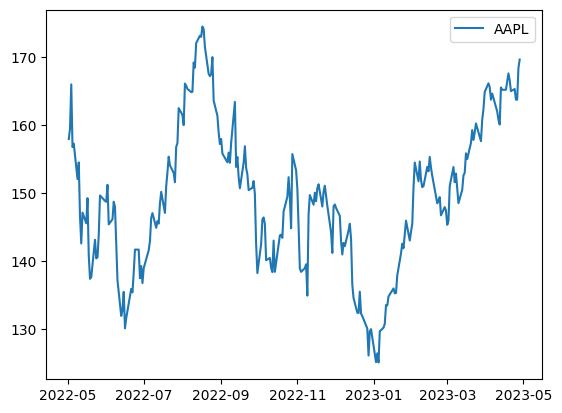

In [4]:
plt.plot(data['Close'])
plt.legend(stock)
plt.show()

**Initial option price: C_0 = exp(-rT) (q C_u + (1-q)C_d)**\
**Option payoff: C_Nj = max(S_Nj-K,0)**\
**Stock tree nodes: S_ij = S_0 u^j d^(i-j)**

In [5]:
S_0 = data['Close'][0]
T_maturity = 1 #in years
risk_free_rate = 0.01
strike_price = 200
N_steps = 100
u = 1.01
d = 1/u
option_type = 'Call'

In [6]:
def binomial_tree(K,T,S0,r,N,u,d,option_type = 'Call'):
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)

    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*d**N
        else: S[j] = S[j-1]*u/d
        if option_type=='Call': C[j] = max(0,S[j]-K)
        else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            C[j] = disc * (q*C[j+1] + (1-q)*C[j]) 
    return C[0]
    
print('C0 = '+str(binomial_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,u=u,d=d,option_type = option_type)))

C0 = 0.0674355677619349


In [7]:
def binomial_barrier_tree(K,T,S0,r,N,u,d,H,option_type = 'Call'):
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)

    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*d**N
        else: S[j] = S[j-1]*u/d
        if S[j]<H:
            if option_type=='Call': C[j] = max(0,S[j]-K)
            else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            if j==0: S[j] = S0*d**N
            else: S[j] = S[j-1]*u/d
            if S[j]<H: C[j] = disc * (q*C[j+1] + (1-q)*C[j]) 
            else: C[j] = 0
    return C[0]
    
print('C0 = '+str(binomial_barrier_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,u=u,d=d,H=210,option_type = option_type)))

C0 = 0.03231808543593788


In [8]:
def binomial_american_tree(K,T,S0,r,N,u,d,option_type = 'Call'):
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)

    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*d**N
        else: S[j] = S[j-1]*u/d
        if option_type=='Call': C[j] = max(0,S[j]-K)
        else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            if j==0: S[j] = S0*d**N
            else: S[j] = S[j-1]*u/d
            C[j] = disc * (q*C[j+1] + (1-q)*C[j]) 
            if option_type=='Call': C[j] = max(C[j],S[j]-K)
            else: C[j] = max(C[j],-S[j]+K)
                
    return C[0]
    
print('C0 = '+str(binomial_american_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,u=u,d=d,option_type = option_type)))

C0 = 0.0674355677619349


**Vectorize the functions making them faster**


In [9]:
def binomial_tree_vect(K,T,S0,r,N,u,d,option_type = 'Call'):
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)

    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
    if option_type=='Call': C = np.maximum( S-K, np.zeros(N+1))
    else: C = np.maximum( -S+K, np.zeros(N+1))
    
    for i in np.arange(N,0,-1):
        C = disc * (q*C[1:i+1] + (1-q)*C[0:i])
    return C[0]
    
print('C0 = '+str(binomial_tree_vect(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,u=u,d=d,option_type = option_type)))

C0 = 0.0674355677619373


In [10]:
def binomial_barrier_tree_vect(K,T,S0,r,N,u,d,H,option_type = 'Call'):
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)

    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
    if option_type=='Call': C = np.maximum( S-K, np.zeros(N+1))
    else: C = np.maximum( -S+K, np.zeros(N+1))
    
    C[S>=H] = 0
    
    for i in np.arange(N-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C = disc * (q*C[1:i+1] + (1-q)*C[0:i])
        C = C[:-1]
        C[S>=H] = 0
    return C[0]
    
print('C0 = '+str(binomial_barrier_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,u=u,d=d,H=210,option_type = option_type)))

C0 = 0.03231808543593788


In [11]:
def binomial_american_tree_vect(K,T,S0,r,N,u,d,option_type = 'Call'):
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)

    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
    if option_type=='Call': C = np.maximum( S-K, np.zeros(N+1))
    else: C = np.maximum( -S+K, np.zeros(N+1))
         
    for i in np.arange(N-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
        C = C[:-1]
        if option_type=='Call': C = np.maximum( S-K, C)
        else: C = np.maximum( -S+K, C)
    return C[0]
    
print('C0 = '+str(binomial_american_tree_vect(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,u=u,d=d,option_type = option_type)))

C0 = 0.0674355677619373


In [12]:
S_0 = data['Close'][-1]
T_maturity = 1 #in years
risk_free_rate = 0.01
strike_price = 180
N_steps = 100
option_type = 'Call'
sigma = data['Close'].pct_change().dropna().std()
print(sigma)

0.02136774460120972


In [13]:
def CRR_binomial_tree(K,T,S0,r,N,sigma,option_type = 'Call'):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = np.exp(-sigma*np.sqrt(dt))
    
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*d**N
        else: S[j] = S[j-1]*u/d
        if option_type=='Call': C[j] = max(0,S[j]-K)
        else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            C[j] = disc * (q*C[j+1] + (1-q)*C[j]) 
    return C[0]
    
print('C0 = '+str(CRR_binomial_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,sigma=sigma,option_type = option_type)))

C0 = 0.01292331668113824


In [14]:
def EQ_binomial_tree(K,T,S0,r,N,sigma,option_type = 'Call'):
    dt = T/N
    nu = r-0.5*sigma**2
    dxu = 0.5*nu*dt+0.5*np.sqrt(4*sigma**2*dt-3*nu**2*dt**2)
    dxd = 1.5*nu*dt-0.5*np.sqrt(4*sigma**2*dt-3*nu**2*dt**2)
    pu = 0.5
    pd = 1-pu
    
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*np.exp(N*dxd)
        else: S[j] = S[j-1]*np.exp(dxu-dxd)
        if option_type=='Call': C[j] = max(0,S[j]-K)
        else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            C[j] = disc * (pu*C[j+1] + pd*C[j]) 
    return C[0]
    
print('C0 = '+str(EQ_binomial_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,sigma=sigma,option_type = option_type)))

C0 = 0.011071124848419758


In [15]:
def JR_binomial_tree(K,T,S0,r,N,sigma,option_type = 'Call'):
    dt = T/N
    nu = r-0.5*sigma**2
    u = np.exp(nu*dt+sigma*np.sqrt(dt))
    d = np.exp(nu*dt-sigma*np.sqrt(dt))
    
    q = (np.exp(r*dt)-d)/(u-d) 
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*d**N
        else: S[j] = S[j-1]*u/d
        if option_type=='Call': C[j] = max(0,S[j]-K)
        else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            C[j] = disc * (q*C[j+1] + (1-q)*C[j]) 
    return C[0]
    
print('C0 = '+str(JR_binomial_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,sigma=sigma,option_type = option_type)))

C0 = 0.013586906029731902


In [16]:
def TRG_binomial_tree(K,T,S0,r,N,sigma,option_type = 'Call'):
    dt = T/N
    nu = r-0.5*sigma**2
    dxu = np.sqrt(sigma**2*dt+nu**2*dt**2)
    dxd = -dxu
    pu = 0.5+0.5*nu*dt/dxu
    pd = 1-pu
    
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    C = np.zeros(N+1)
    
    for j in range(0,N+1):
        if j==0: S[j] = S0*np.exp(N*dxd)
        else: S[j] = S[j-1]*np.exp(dxu-dxd)
        if option_type=='Call': C[j] = max(0,S[j]-K)
        else: C[j] = max(0,-S[j]+K)
    
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            C[j] = disc * (pu*C[j+1] + pd*C[j]) 
    return C[0]
    
print('C0 = '+str(TRG_binomial_tree(K=strike_price,T=T_maturity,S0=S_0,r=risk_free_rate,N=N_steps,sigma=sigma,option_type = option_type)))

C0 = 0.013049929670620408


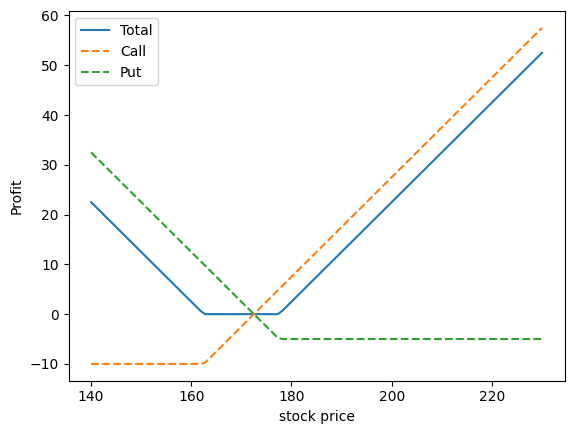

In [44]:
S0 = 170
ds = 15/2
K_call= S0-ds
K_put = S0+ds
premium_call = 10
premium_put = 5
S = np.linspace(140,230,100)
call = np.maximum(0,S-K_call)
put = np.maximum(0,-S+K_put)

profit = (call-premium_call)+(put-premium_put)
# profit = 2*ds -(sum of premuimus)
# to have a non zero profit at all times we need
# ds >= 0.5*(sum of premuiums)
plt.plot(S,profit,label='Total')
plt.plot(S,call-premium_call,label='Call',linestyle='dashed')
plt.plot(S,put-premium_put,label='Put',linestyle='dashed')
plt.ylabel('Profit')
plt.xlabel('stock price')
plt.legend()
plt.show()

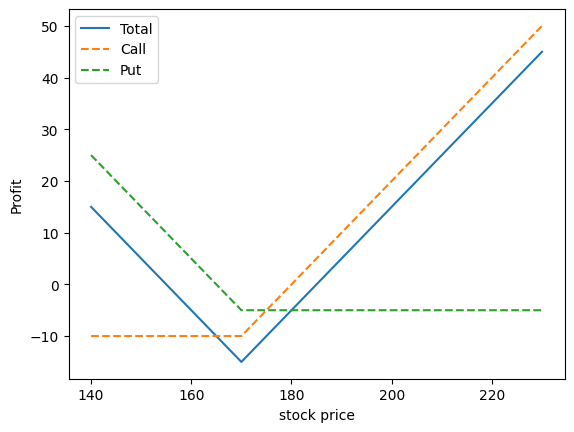

In [47]:
S0 = 170
ds = 0.
K_call= S0+ds
K_put = S0-ds
premium_call = 10
premium_put = 5

S = np.linspace(140,230,100)
call = np.maximum(0,S-K_call)
put = np.maximum(0,-S+K_put)

profit = (call-premium_call)+(put-premium_put)
#depth of loss = 2*ds+sum of premiums
plt.plot(S,profit,label='Total')
plt.plot(S,call-premium_call,label='Call',linestyle='dashed')
plt.plot(S,put-premium_put,label='Put',linestyle='dashed')
plt.ylabel('Profit')
plt.xlabel('stock price')
plt.legend()
plt.show()